In [1]:
import tobac
import numpy as np
import matplotlib.pyplot as plt

import datetime
import xarray as xr

x_min, y_min, x_max, y_max, = 0, 0, 10, 10
t_min, t_max = 0, 10

x = np.linspace(x_min, x_max, 200)
y = np.linspace(y_min, y_max, 200)
t = np.linspace(t_min, t_max, 5)

tt, yy, xx = np.meshgrid(t, y, x, indexing='ij')

def create_wandering_blob(x_0, y_0, v_x, v_y, t_create, t_vanish, sigma):

    exponent = (xx - x_0 - v_x*(tt-t_create))**2 + (yy - y_0 - v_y*(tt-t_create))**2
    feature_alive = np.logical_and(tt>=t_create , tt<=t_vanish)
    blob = np.where(feature_alive, np.exp(-exponent/sigma), 0)
    
    return blob

def create_xarray(array):

    t_0 = np.datetime64('2022-04-01T00:00')
    t_delta = np.timedelta64(1, 'm')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y
             }
    
    attributes = {'units': ('m s-1')}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

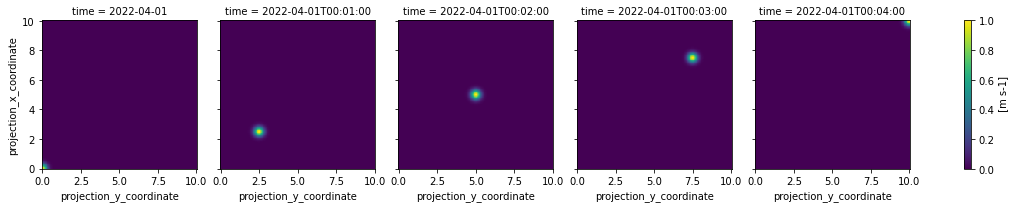

In [2]:
%matplotlib inline

blob = create_wandering_blob(0, 0, 1, 1, 0, 10, 0.1)
data = create_xarray(blob)
data.plot(cmap = 'viridis', col='time', col_wrap=5)

Frame 4: 1 trajectories present.


Text(0.5, 1.0, 'predict')

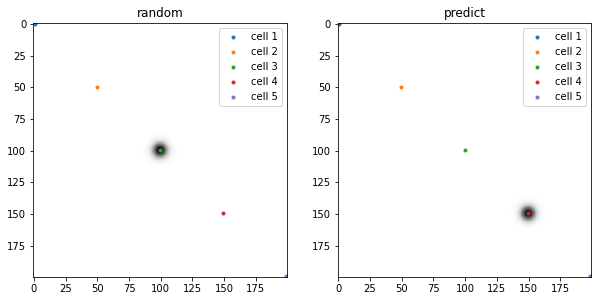

In [3]:
%matplotlib inline

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/200)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.9)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=3,
                                              method_linking='random')

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=3, 
                                              method_linking='predict')

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(blob[2], cmap = 'Greys', alpha = 1)
ax2.imshow(blob[3], cmap = 'Greys', alpha = 1)

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='.',
            linestyle='') 
ax1.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='.',
            linestyle='')
ax2.legend()
ax2.set_title('predict')

In [2]:
blob_1 = create_wandering_blob(0, 0, 1, 1, 0, 10, 0.1)
blob_2 = create_wandering_blob(8, 2.5, -0.5, 0.5, 0, 10, 0.2)
#blob_3 = create_wandering_blob(2, 0, 1, 1, 0, 10, 0.1)
blob_mask = blob_1 > blob_2

blob = np.where(blob_mask, blob_1, blob_2)

data = create_xarray(blob)

<IPython.core.display.Javascript object>


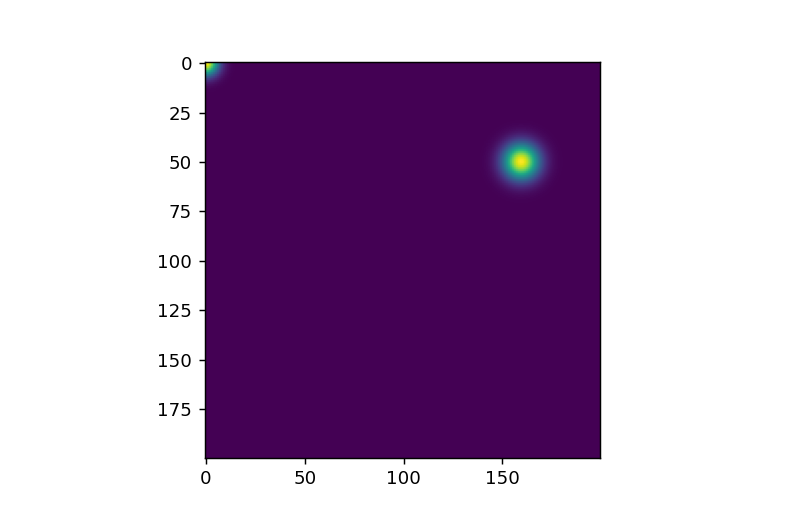

In [7]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots()

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 5)

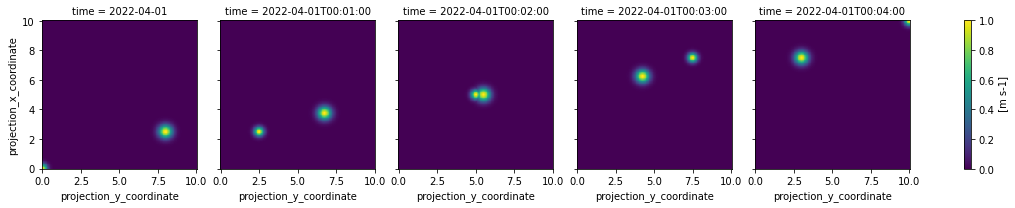

In [8]:
%matplotlib inline
data.plot(cmap = 'viridis', col='time', col_wrap=5)

Frame 4: 2 trajectories present.


Text(0.5, 1.0, 'predict')

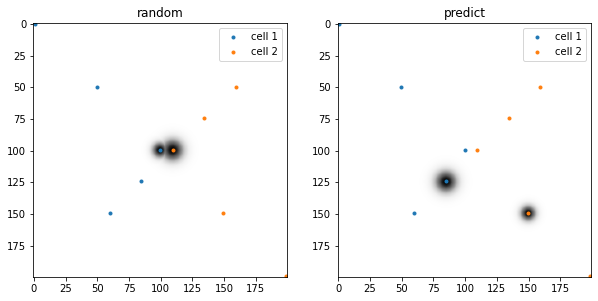

In [14]:
%matplotlib inline

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/200)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.9)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=10,
                                              method_linking='random',
                                              subnetwork_size=2)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=10, 
                                              method_linking='predict',
                                              subnetwork_size=2)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(blob[2], cmap = 'Greys', alpha = 1)
ax2.imshow(blob[3], cmap = 'Greys', alpha = 1)

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='.',
            linestyle='') 
ax1.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='.',
            linestyle='')
ax2.legend()
ax2.set_title('predict')

In [6]:
int(100 / dxy)

2000

In [20]:
features.to_dataframe().to_csv('dat.csv')

In [82]:
import trackpy as tp
import pandas as pd

Frame 4: 2 trajectories present.


Text(0.5, 1.0, 'predict')

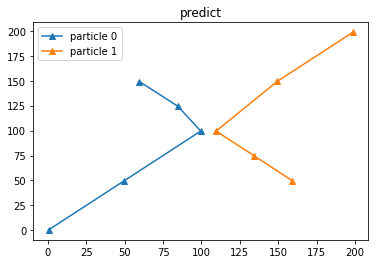

In [55]:
pred = tp.predict.NearestVelocityPredict(span=1)
#pred = tp.predict.instrumented()(tp.predict.NearestVelocityPredict)(span=2)
traj = pred.link_df(
            features.to_dataframe(),
            search_range=4,
            pos_columns=["projection_x_coordinate", "projection_y_coordinate"])

fig, ax1 = plt.subplots()

for i, track_i in traj.groupby('particle'):
    ax1.plot(track_i.sort_values('frame')['hdim_2'], 
             track_i.sort_values('frame')['hdim_1'],
            label='particle {}'.format(int(i)),
            marker ='^',
            linestyle='-') 
ax1.legend()
ax1.set_title('predict')

In [83]:
df_list = [frame for i, frame in features.to_dataframe().groupby('frame')]

In [78]:
pred = tp.predict.NearestVelocityPredict(span=1)
#pred = tp.predict.instrumented()(tp.predict.NearestVelocityPredict)(span=2)
traj = pred.link_df_iter(
            df_list,
            search_range=4,
            pos_columns=["projection_x_coordinate", "projection_y_coordinate"])

In [79]:
traj = pd.concat(traj)

Frame 4: 2 trajectories present.


In [80]:
df_list

[       frame  idx  hdim_1  hdim_2  num  threshold_value  feature  \
 index                                                              
 0          0    1    0.50    0.50    4              0.9        1   
 1          0    2   49.72  159.12   25              0.9        2   
 
                       time              timestr  projection_x_coordinate  \
 index                                                                      
 0      2022-04-01 00:00:00  2022-04-01 00:00:00                 0.025126   
 1      2022-04-01 00:00:00  2022-04-01 00:00:00                 2.498492   
 
        projection_y_coordinate  
 index                           
 0                     0.025126  
 1                     7.995980  ,
        frame  idx     hdim_1      hdim_2  num  threshold_value  feature  \
 index                                                                     
 2          1    1  49.615385   49.615385   13              0.9        3   
 3          1    2  74.653846  134.346154   26 

Text(0.5, 1.0, 'predict')

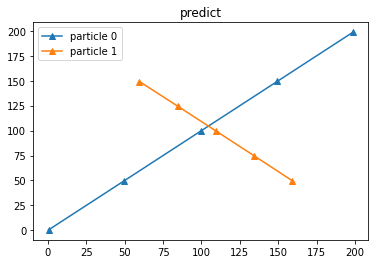

In [81]:
fig, ax1 = plt.subplots()

for i, track_i in traj.groupby('particle'):
    ax1.plot(track_i.sort_values('frame')['hdim_2'], 
             track_i.sort_values('frame')['hdim_1'],
            label='particle {}'.format(int(i)),
            marker ='^',
            linestyle='-') 
ax1.legend()
ax1.set_title('predict')

In [332]:
trajectories_unfiltered.where(trajectories_unfiltered['frame'] == 3)

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_x_coordinate,projection_y_coordinate,ncells,particle
index,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,29.5,19.5,4.0,0.95,4.0,2022-04-01 00:03:00,2022-04-01 00:03:00,6.020408,3.979592,52.0,0.0
4,3.0,2.0,29.5,29.5,4.0,0.95,5.0,2022-04-01 00:03:00,2022-04-01 00:03:00,6.020408,6.020408,52.0,1.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


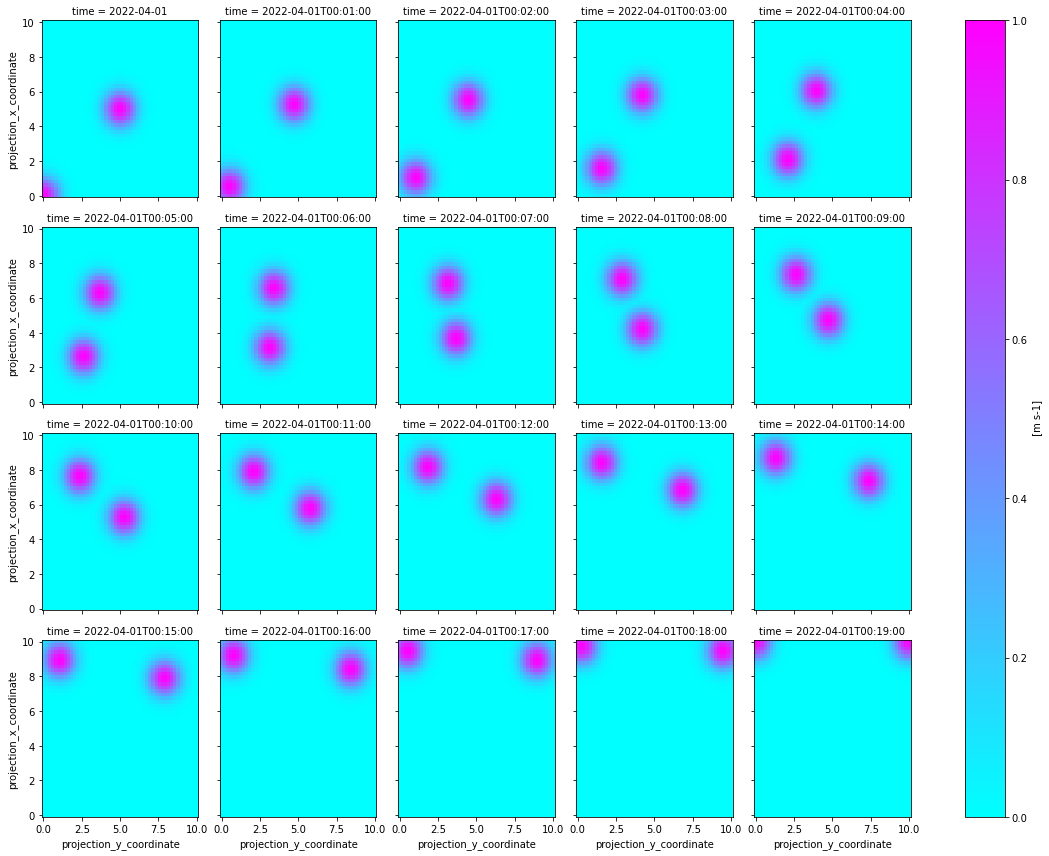

In [20]:
%matplotlib inline

data.plot(cmap = 'cool', col='time', col_wrap=5)

In [103]:
46/17

2.7058823529411766

In [241]:
for i in range(5):
    
    if i == 0:
        blob = create_wandering_blob(0, i, 1, 1, 0)
    else:
        blob += create_wandering_blob(0, i, 1, 1, 0)
        
data = create_xarray(blob)

<IPython.core.display.Javascript object>


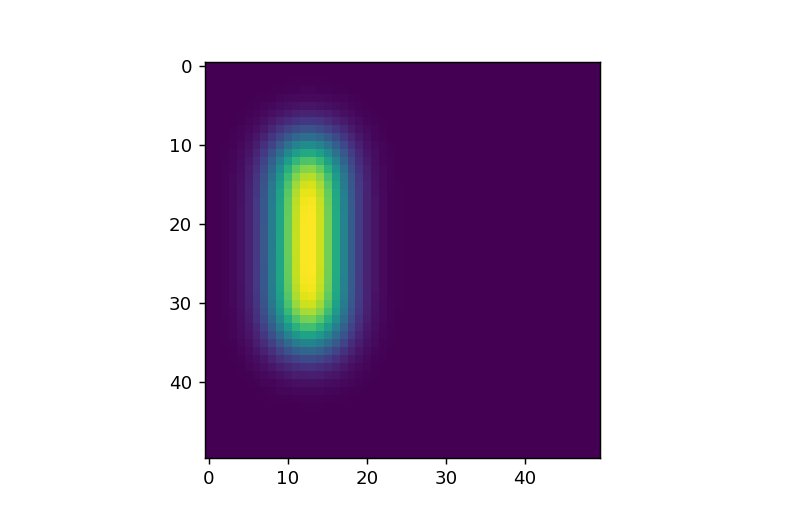

In [242]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots()

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 40)

Frame 39: 1 trajectories present.


Text(0.5, 1.0, 'predict')

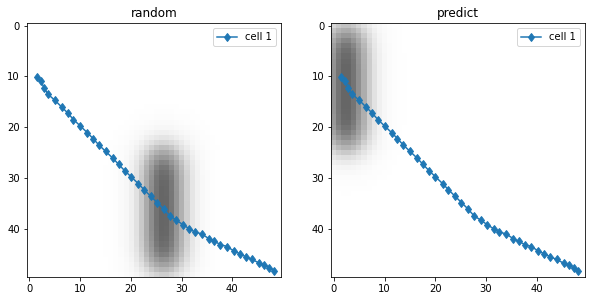

In [243]:
%matplotlib inline

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/50)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.95)
#mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.3)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1.5,
                                              method_linking='random',
                                              subnetwork_size=2)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1.5, 
                                              method_linking='predict',
                                              subnetwork_size=2)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(blob[21], cmap = 'Greys', alpha = 0.6)
ax2.imshow(blob[2], cmap = 'Greys', alpha = 0.6)

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='d',
            linestyle='-') 
ax1.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='d',
            linestyle='-')
ax2.legend()
ax2.set_title('predict')

In [250]:
np.random.seed(12345)

for i in range(100):
    
    x_0 = np.random.random()*10
    y_0 = np.random.random()*10
    v_x = np.random.random()*0.1 - 0.05
    v_y = np.random.random()*0.1 - 0.05
    t_min = 0
    t_max = np.random.random()*(10-t_min) + t_min
    sigma = np.random.random()*0.1
    
    if i == 0:
        blob = create_wandering_blob(x_0, y_0, v_x, v_y, t_min, t_max, sigma)
    else:
        blob += create_wandering_blob(x_0, y_0, v_x, v_y, t_min, t_max, sigma)
        
data = create_xarray(blob)

<IPython.core.display.Javascript object>


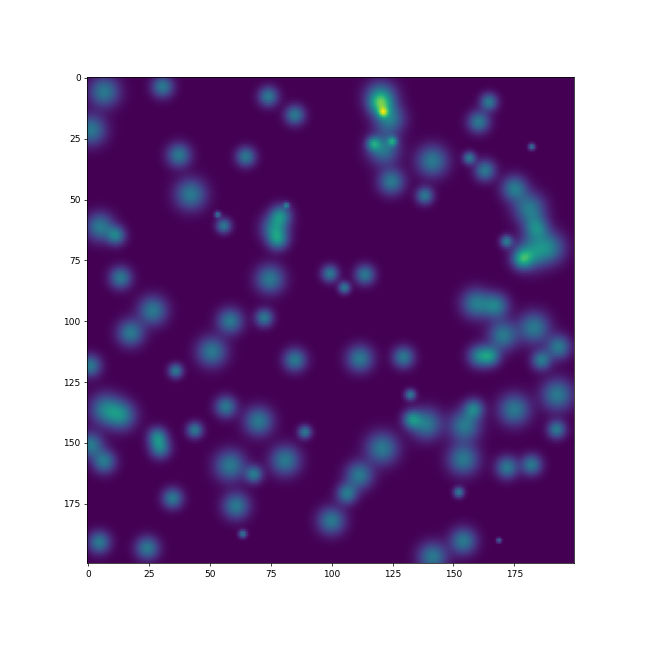

In [251]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots(figsize = (10, 10))

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 50)

Frame 199: 71 trajectories present.


Text(0.5, 1.0, 'predict')

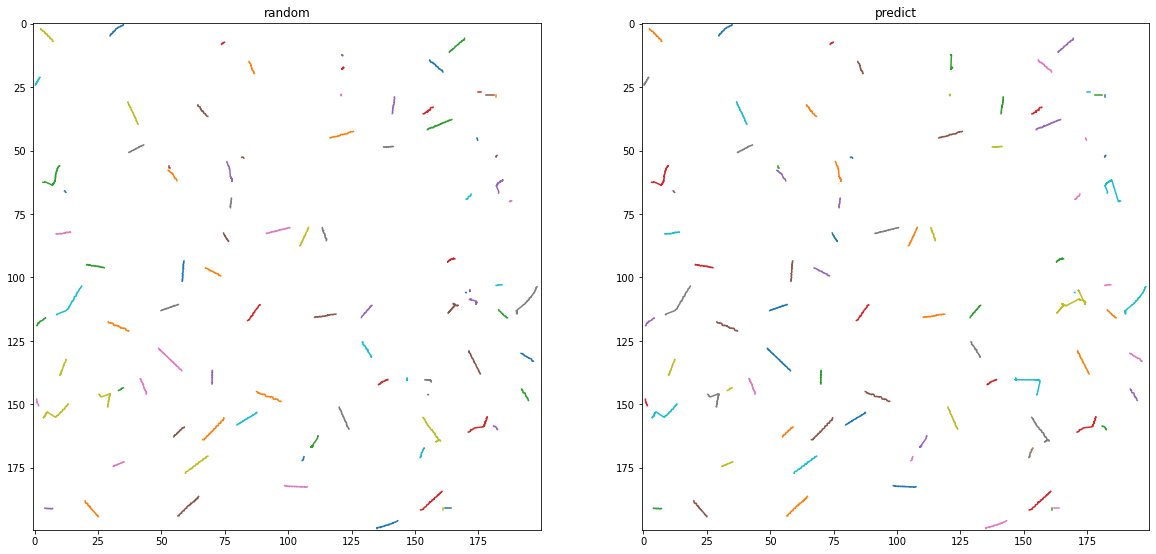

In [260]:
%matplotlib inline

dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/50)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.7)
#mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=0.3)

track1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=1,
                                              method_linking='random',
                                              subnetwork_size=30)

track2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=2, 
                                              method_linking='predict',
                                              subnetwork_size=30)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.imshow(blob[0], cmap = 'Greys', alpha = 0)
ax2.imshow(blob[0], cmap = 'Greys', alpha = 0)

for i, track_i in track1.groupby('cell'):
    ax1.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-') 
#ax1.legend()
ax1.set_title('random')

for i, track_i in track2.groupby('cell'):
    ax2.plot(track_i.sortby('frame')['hdim_2'], 
             track_i.sortby('frame')['hdim_1'],
            label='cell {}'.format(int(i)),
            marker ='',
            linestyle='-')
#ax2.legend()
ax2.set_title('predict')

In [261]:
track1['cell'].max()

<xarray.DataArray 'cell' ()>
array(99.)

In [288]:


track1['time_cell']*1e-9

<xarray.DataArray 'time_cell' (index: 14350)>
array([    0,     0,     0, ..., 11940, 11940, 11940],
      dtype='timedelta64[ns]')
Coordinates:
  * index    (index) int64 0 55 54 53 52 51 ... 14299 14298 14297 14313 14349

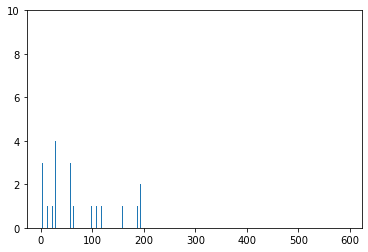

In [287]:
fig, ax = plt.subplots()
tobac.plot.plot_lifetime_histogram_bar(track1, axes = ax, bin_edges = np.arange(0, 10*60, 5))
ax.set_ybound(0, 10)

In [266]:
help(tobac.plot.plot_lifetime_histogram)

Help on function wrapper in module tobac.utils.convert:

wrapper(*args, **kwargs)

